In [1]:
import numpy as np
import os
from keras.layers import Conv3D, MaxPooling3D
from keras.layers import Dense, Dropout, Flatten
from keras.models import Sequential
from keras.layers import Activation, ZeroPadding3D, TimeDistributed, LSTM, GRU, Reshape
#from keras.utils import plot_model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import gc
from sklearn.metrics import classification_report, balanced_accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
from sklearn.preprocessing import LabelEncoder
import sklearn
import seaborn as sns
import tensorflow as tf
from keras import regularizers
from tensorflow.keras.utils import to_categorical
from prettytable import PrettyTable
from matplotlib import pyplot as plt

import time

# Noise Reduction 

In [5]:
import cv2
import os

def reduce_noise(input_folder, output_folder):
    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Loop through each file in the input folder
    for filename in os.listdir(input_folder):
        if filename.endswith(".mp4"):  # Assuming all files are videos
            video_path = os.path.join(input_folder, filename)
            output_path = os.path.join(output_folder, filename)

            # Open the video file
            cap = cv2.VideoCapture(video_path)
            frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
            frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
            fps = int(cap.get(cv2.CAP_PROP_FPS))

            # Create VideoWriter object
            fourcc = cv2.VideoWriter_fourcc(*'mp4v')
            out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

            # Process each frame
            for _ in range(frame_count):
                ret, frame = cap.read()
                if ret:
                    # Apply Gaussian blur for noise reduction
                    blurred_frame = cv2.GaussianBlur(frame, (5, 5), 0)
                    out.write(blurred_frame)

            # Release resources
            cap.release()
            out.release()

            print(f"Noise reduction completed for {filename}")

# Example usage:
input_folder = "D:\\FINAL MAJOR20-2\\Dataset1.0"
output_folder = "D:\\FINAL MAJOR20-2\\Noise reduction\\output"
reduce_noise(input_folder, output_folder)


Noise reduction completed for a.mp4
Noise reduction completed for bye.mp4
Noise reduction completed for can.mp4
Noise reduction completed for cat.mp4
Noise reduction completed for demo.mp4
Noise reduction completed for dog.mp4
Noise reduction completed for hello.mp4
Noise reduction completed for here.mp4
Noise reduction completed for is.mp4
Noise reduction completed for lips.mp4
Noise reduction completed for my.mp4
Noise reduction completed for read.mp4
Noise reduction completed for you.mp4


# Converting to Frames

In [6]:
import os
import cv2

def extract_frames(video_folder, output_folder, num_frames=8):
    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Iterate through each video file in the folder
    for filename in os.listdir(video_folder):
        if filename.endswith(".mp4") or filename.endswith(".avi"):
            video_path = os.path.join(video_folder, filename)
            video_name = os.path.splitext(filename)[0]

            # Create a subfolder for each video
            video_output_folder = os.path.join(output_folder, video_name)
            if not os.path.exists(video_output_folder):
                os.makedirs(video_output_folder)

            # Open the video file
            cap = cv2.VideoCapture(video_path)

            # Get the total number of frames in the video
            total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

            # Calculate the frame interval to get exactly num_frames frames
            frame_interval = max(1, total_frames // num_frames)

            frame_count = 0

            # Read and process each frame
            while(cap.isOpened() and frame_count < num_frames):
                ret, frame = cap.read()
                if not ret:
                    break

                # Save the frame
                output_frame_path = os.path.join(video_output_folder, f"{video_name}_frame_{frame_count}.jpg")
                cv2.imwrite(output_frame_path, frame)

                frame_count += 1

                # Move to the next frame based on the calculated interval
                cap.set(cv2.CAP_PROP_POS_FRAMES, frame_count * frame_interval)

            cap.release()

# Example usage:
video_dataset_folder = "D:\\FINAL MAJOR20-2\\Noise reduction\\output"
output_frames_folder = "D:\\FINAL MAJOR20-2\\Frames"
extract_frames(video_dataset_folder, output_frames_folder, num_frames=8)


# Converting Normal Frames into GLCM

In [7]:
import os
import cv2
import numpy as np
from skimage.feature import graycomatrix, graycoprops

def glcm_noise_reduction(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Compute the GLCM of the grayscale image
    glcm = graycomatrix(gray, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4])

    # Compute the mean of the GLCM
    mean_glcm = np.mean(glcm)

    # Subtract the mean from the original image to reduce noise
    reduced_noise_image = gray - mean_glcm

    return reduced_noise_image

# Specify the directory containing the folders with frames
root_dir = "D:\\FINAL MAJOR20-2\\Frames"

# Create a new folder to save all the noise-reduced images
new_root_dir = "D:\\FINAL MAJOR20-2\\output_denoised_image_folder"

# Loop over each folder (video)
for folder in os.listdir(root_dir):
    folder_path = os.path.join(root_dir, folder)
    new_folder_path = os.path.join(new_root_dir, folder)
    os.makedirs(new_folder_path, exist_ok=True)

    # Loop over each image (frame) in the folder
    for frame in os.listdir(folder_path):
        frame_path = os.path.join(folder_path, frame)

        # Read the image
        image = cv2.imread(frame_path)

        # Apply GLCM noise reduction
        reduced_noise_image = glcm_noise_reduction(image)

        # Save the noise-reduced image in the new folder
        cv2.imwrite(os.path.join(new_folder_path, frame), reduced_noise_image)

print('Noise reduction completed.')


Noise reduction completed.


# VGG_lstm


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Input, Reshape
from sklearn.model_selection import KFold
from tensorflow.keras.applications import MobileNetV2, VGG16
import time

# Define constants
IMAGE_SIZE = (96, 72)
BATCH_SIZE = 16
EPOCHS = 100
NUM_CLASSES = 17
TRAIN_DATA_DIR = "C:\\Users\\sumit\\Downloads\\Saquib\\output_denoised_image_folder"
K_FOLDS = 5

# Load the data
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

data_generator = datagen.flow_from_directory(
    TRAIN_DATA_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

# Initialize KFold
kf = KFold(n_splits=K_FOLDS, shuffle=True)

# Initialize arrays to store accuracies and computational times
train_accuracies = []
val_accuracies = []

comp_times = []

# Load pre-trained VGG-16 model, excluding the top classifier layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

# Freeze pre-trained layers to prevent them from being updated during training
for layer in base_model.layers:
    layer.trainable = False

# Define the model architecture
inputs = Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))  # Input layer for images

# Extract features using VGG-16
vgg_features = base_model(inputs)

# **Reshape features to ensure compatibility with LSTM (remove unnecessary dimension):**
# Adjust the shape based on the actual dimensions of `vgg_features` (e.g., if features are (None, 7, 7, 512), reshape to (None, 7, 512))
desired_feature_shape = (vgg_features.shape[1], vgg_features.shape[2] * vgg_features.shape[3])  # Calculate desired shape
reshaped_features = Reshape(desired_feature_shape)(vgg_features)

# Define the LSTM-based classifier
lstm_1 = LSTM(128, return_sequences=True)(reshaped_features)  # First LSTM layer
lstm_2 = LSTM(32)(lstm_1)                                     # Second LSTM layer

Dropout(0.7)
# Final dense layer for classification
predictions = Dense(NUM_CLASSES, activation='softmax')(lstm_2)

# Create the final model
model = tf.keras.Model(inputs=inputs, outputs=predictions)
# Compile the model
model.compile(optimizer=tf.keras.optimizers.SGD(clipnorm=1),  # Create Adam optimizer with clipnorm
              loss='categorical_crossentropy',
              metrics=['accuracy'],
              run_eagerly=True,  # Enables early stopping callbacks
              )

# Track start time
start_time = time.time()

# K-fold cross-validation loop
for fold, (train_index, val_index) in enumerate(kf.split(data_generator), 1):
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2
    ).flow_from_directory(
        TRAIN_DATA_DIR,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True,
        subset='training',
        seed=42
    )

    validation_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2
    ).flow_from_directory(
        TRAIN_DATA_DIR,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False,
        subset='validation',
        seed=42
    )

    # Train the model
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // BATCH_SIZE,
        verbose=1
    )

    # Evaluate the model
    train_loss, train_acc = model.evaluate(train_generator)
    val_loss, val_acc = model.evaluate(validation_generator)

    print(f"Fold {fold}:")
    print(f"Train accuracy: {train_acc}, Validation accuracy: {val_acc}")
    print(f"Training time for fold {fold}: {time.time() - start_time} seconds\n")

    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    comp_times.append(time.time() - start_time)

    # Save the model for this fold
    model.save(f'VGG-lstm_kfold(1)_{fold}.h5')

# Track end time
end_time = time.time()

print("K-Fold Cross Validation Complete.")
# Print average accuracies and computational time
print("Average Training Accuracy:", np.mean(train_accuracies)*100,"%")
print("Average Validation Accuracy:", np.mean(val_accuracies)*100,"%")
print("Average Training Time:", np.mean(comp_times))
print("Total Training Time:", end_time - start_time)


Found 298 images belonging to 17 classes.
Found 246 images belonging to 17 classes.
Found 52 images belonging to 17 classes.
Epoch 1/100
15/15 [==============================] - 10s 218ms/step - loss: 2.8523 - accuracy: 0.0696 - val_loss: 2.8357 - val_accuracy: 0.0625
Epoch 2/100
15/15 [==============================] - 2s 116ms/step - loss: 2.8465 - accuracy: 0.0739 - val_loss: 2.8314 - val_accuracy: 0.0833
Epoch 3/100
15/15 [==============================] - 2s 115ms/step - loss: 2.8427 - accuracy: 0.0739 - val_loss: 2.8306 - val_accuracy: 0.0833
Epoch 4/100
15/15 [==============================] - 2s 113ms/step - loss: 2.8360 - accuracy: 0.0696 - val_loss: 2.8256 - val_accuracy: 0.0833
Epoch 5/100
15/15 [==============================] - 2s 112ms/step - loss: 2.8322 - accuracy: 0.0739 - val_loss: 2.8241 - val_accuracy: 0.0833
Epoch 6/100
15/15 [==============================] - 2s 113ms/step - loss: 2.8290 - accuracy: 0.0750 - val_loss: 2.8210 - val_accuracy: 0.1042
Epoch 7/100
15/1

# Training accuracy

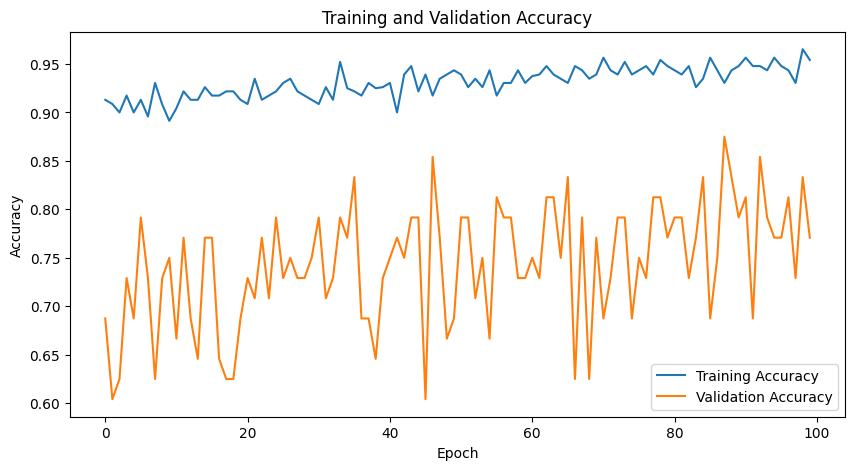

In [3]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# ROC CURVE

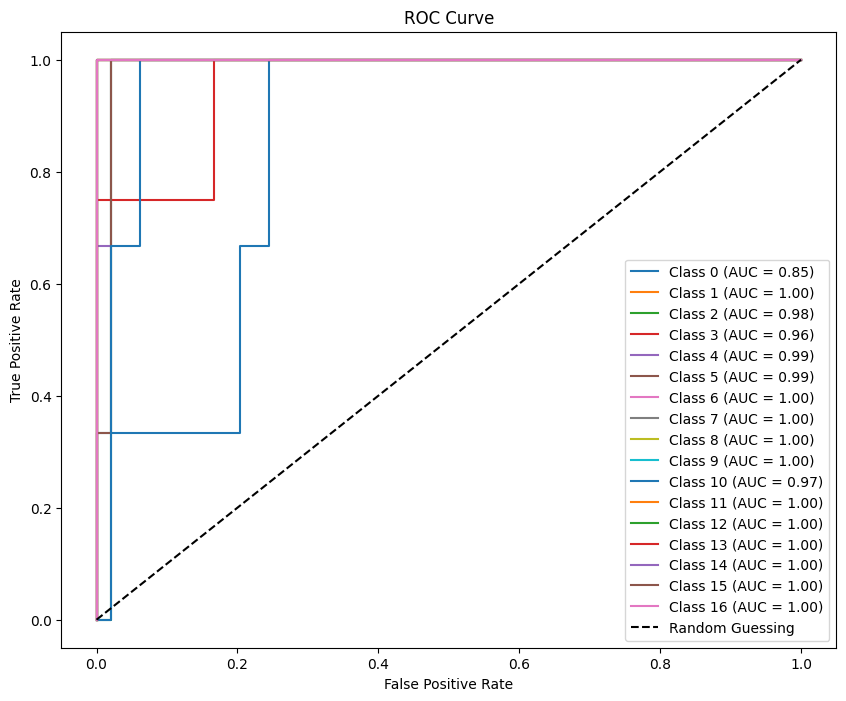

In [4]:
y_pred = model.predict(validation_generator)
y_true = validation_generator.classes
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve((y_true == i).astype(int), y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 8))
for i in range(NUM_CLASSES):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Confusion Matrix

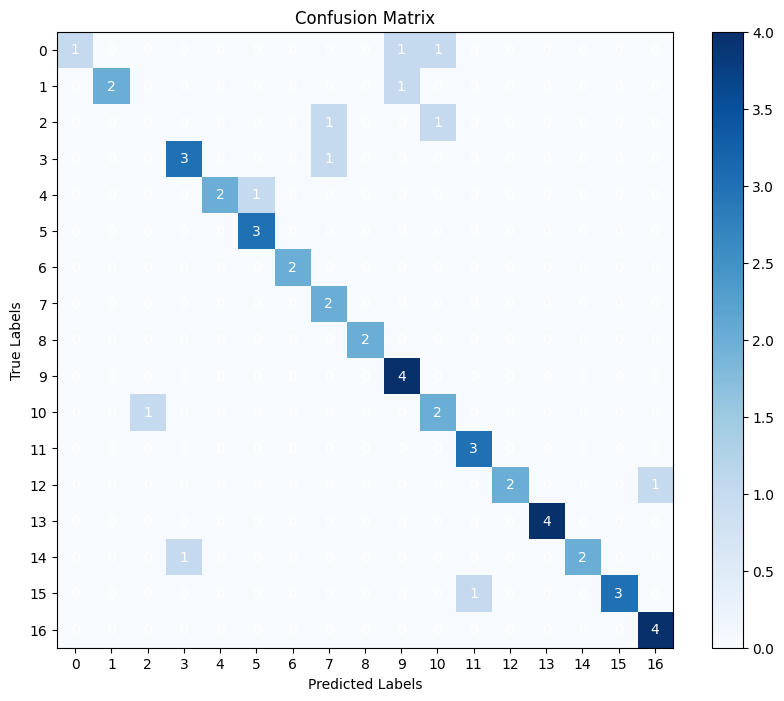

In [5]:
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(y_true, np.argmax(y_pred, axis=1))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(np.arange(NUM_CLASSES))
plt.yticks(np.arange(NUM_CLASSES))
for i in range(NUM_CLASSES):
    for j in range(NUM_CLASSES):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='white')
plt.show()


# F1 score support

In [6]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from prettytable import PrettyTable
import pandas as pd
import time

# Assuming you already have the necessary variables defined in your code
train_predictions = model.predict(train_generator)
validation_predictions = model.predict(validation_generator)

# Convert predictions to class labels
train_pred_labels = np.argmax(train_predictions, axis=1)
validation_pred_labels = np.argmax(validation_predictions, axis=1)

# True labels for training and validation sets
train_true_labels = train_generator.classes
validation_true_labels = validation_generator.classes

# Calculate metrics
train_report = classification_report(train_true_labels, train_pred_labels, target_names=train_generator.class_indices)
validation_report = classification_report(validation_true_labels, validation_pred_labels, target_names=validation_generator.class_indices)

# Additional metrics using confusion matrix
train_conf_matrix = confusion_matrix(train_true_labels, train_pred_labels)
validation_conf_matrix = confusion_matrix(validation_true_labels, validation_pred_labels)

# Calculate precision, recall, F1 score, and support
train_precision, train_recall, train_f1_score, train_support = precision_recall_fscore_support(train_true_labels, train_pred_labels)
validation_precision, validation_recall, validation_f1_score, validation_support = precision_recall_fscore_support(validation_true_labels, validation_pred_labels)

# Create PrettyTable for training metrics
train_table = PrettyTable()
train_table.field_names = ["Class", "Precision", "Recall", "F1 Score", "Support"]

# Populate the table with training metrics
for class_name, precision, recall, f1_score, support in zip(
        train_generator.class_indices.keys(),
        train_precision,
        train_recall,
        train_f1_score,
        train_support
):
    train_table.add_row([class_name, precision, recall, f1_score, support])

# Create PrettyTable for validation metrics
validation_table = PrettyTable()
validation_table.field_names = ["Class", "Precision", "Recall", "F1 Score", "Support"]

# Populate the table with validation metrics
for class_name, precision, recall, f1_score, support in zip(
        validation_generator.class_indices.keys(),
        validation_precision,
        validation_recall,
        validation_f1_score,
        validation_support
):
    validation_table.add_row([class_name, precision, recall, f1_score, support])

# Print tables
print("Training Metrics:")
print(train_table)

print("\nValidation Metrics:")
print(validation_table)

# ... (your existing code)

# Create DataFrames for training and validation metrics
train_df = pd.DataFrame({
    'Dataset': 'Training',
    'Class': list(train_generator.class_indices.keys()),
    'Precision': train_precision,
    'Recall': train_recall,
    'F1 Score': train_f1_score,
    'Support': train_support
})

validation_df = pd.DataFrame({
    'Dataset': 'Validation',
    'Class': list(validation_generator.class_indices.keys()),
    'Precision': validation_precision,
    'Recall': validation_recall,
    'F1 Score': validation_f1_score,
    'Support': validation_support
})

# Concatenate DataFrames
combined_df = pd.concat([train_df, validation_df], ignore_index=True)

# Save combined DataFrame to an Excel sheet
combined_excel_path = 'combined_metricsVGG-lstmkfold5.xlsx'
combined_df.to_excel(combined_excel_path, index=False)

print(f"Combined metrics saved to {combined_excel_path}")



Training Metrics:
+-------+---------------------+---------------------+----------------------+---------+
| Class |      Precision      |        Recall       |       F1 Score       | Support |
+-------+---------------------+---------------------+----------------------+---------+
|   0   |  0.2727272727272727 | 0.23076923076923078 |         0.25         |    13   |
|   1   | 0.14285714285714285 | 0.13333333333333333 | 0.13793103448275862  |    15   |
|   10  | 0.18181818181818182 | 0.16666666666666666 | 0.17391304347826086  |    12   |
|   2   | 0.16666666666666666 | 0.16666666666666666 | 0.16666666666666666  |    18   |
|   3   | 0.08333333333333333 | 0.07692307692307693 |         0.08         |    13   |
|   4   |         0.0         |         0.0         |         0.0          |    15   |
|   5   |         0.0         |         0.0         |         0.0          |    12   |
|   6   | 0.07142857142857142 | 0.08333333333333333 | 0.07692307692307693  |    12   |
|   7   | 0.0833333333333